In [1]:
# uncomment on first runs
!git clone https://github.com/trung8134/NCKH_xAI.gitz

Cloning into 'NCKH-FR-2023'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 102 (delta 19), reused 29 (delta 12), pack-reused 66
Receiving objects: 100% (102/102), 41.42 KiB | 5.92 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
pip install gdown

In [ ]:
# Nếu dùng colab thì hãy chạy line này
import os
import gdown

# Đi tới thư mục chính
os.chdir('NCKH_xAI')

# Tạo thư mục 'datasets'
os.makedirs('Datasets', exist_ok=True)

# Lưu lại thư mục làm việc hiện tại
current_directory = os.getcwd()

# Di chuyển đến thư mục 'datasets'
os.chdir('Datasets')

# URL chia sẻ của tệp bạn muốn tải xuống từ Google Drives
file_url = 'https://drive.google.com/uc?id=198z59C3HVKv1scCwkj5bdzIqPqjE2OsO'

# Sử dụng gdown.download để tải xuống tệp
gdown.download(file_url, output='data.zip')

# Giải nén tệp nếu cần thiết
os.system('unzip data.zip')

# Quay lại thư mục trước 'datasets'
os.chdir(current_directory)

# Contrastive Classification



In [ ]:
!pip install tensorflow-addons
!pip install git+https://github.com/qubvel/classification_models.git

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from models import ResNet50_model, EfficientNetB3_model
from dataset import split_data, create_gens
from callbacks import MyCallback
from plot_history_of_training import plot_training

# Start Reading Dataset

Load datasets

In [3]:
data_dir = 'C:/Users/caotr/D. Computer Science/Data Science/DL/Project/NCKH-2024/Datasets/training'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 8692 validated image filenames belonging to 11 classes.
Found 1086 validated image filenames belonging to 11 classes.
Found 1087 validated image filenames belonging to 11 classes.


Visualization samples images

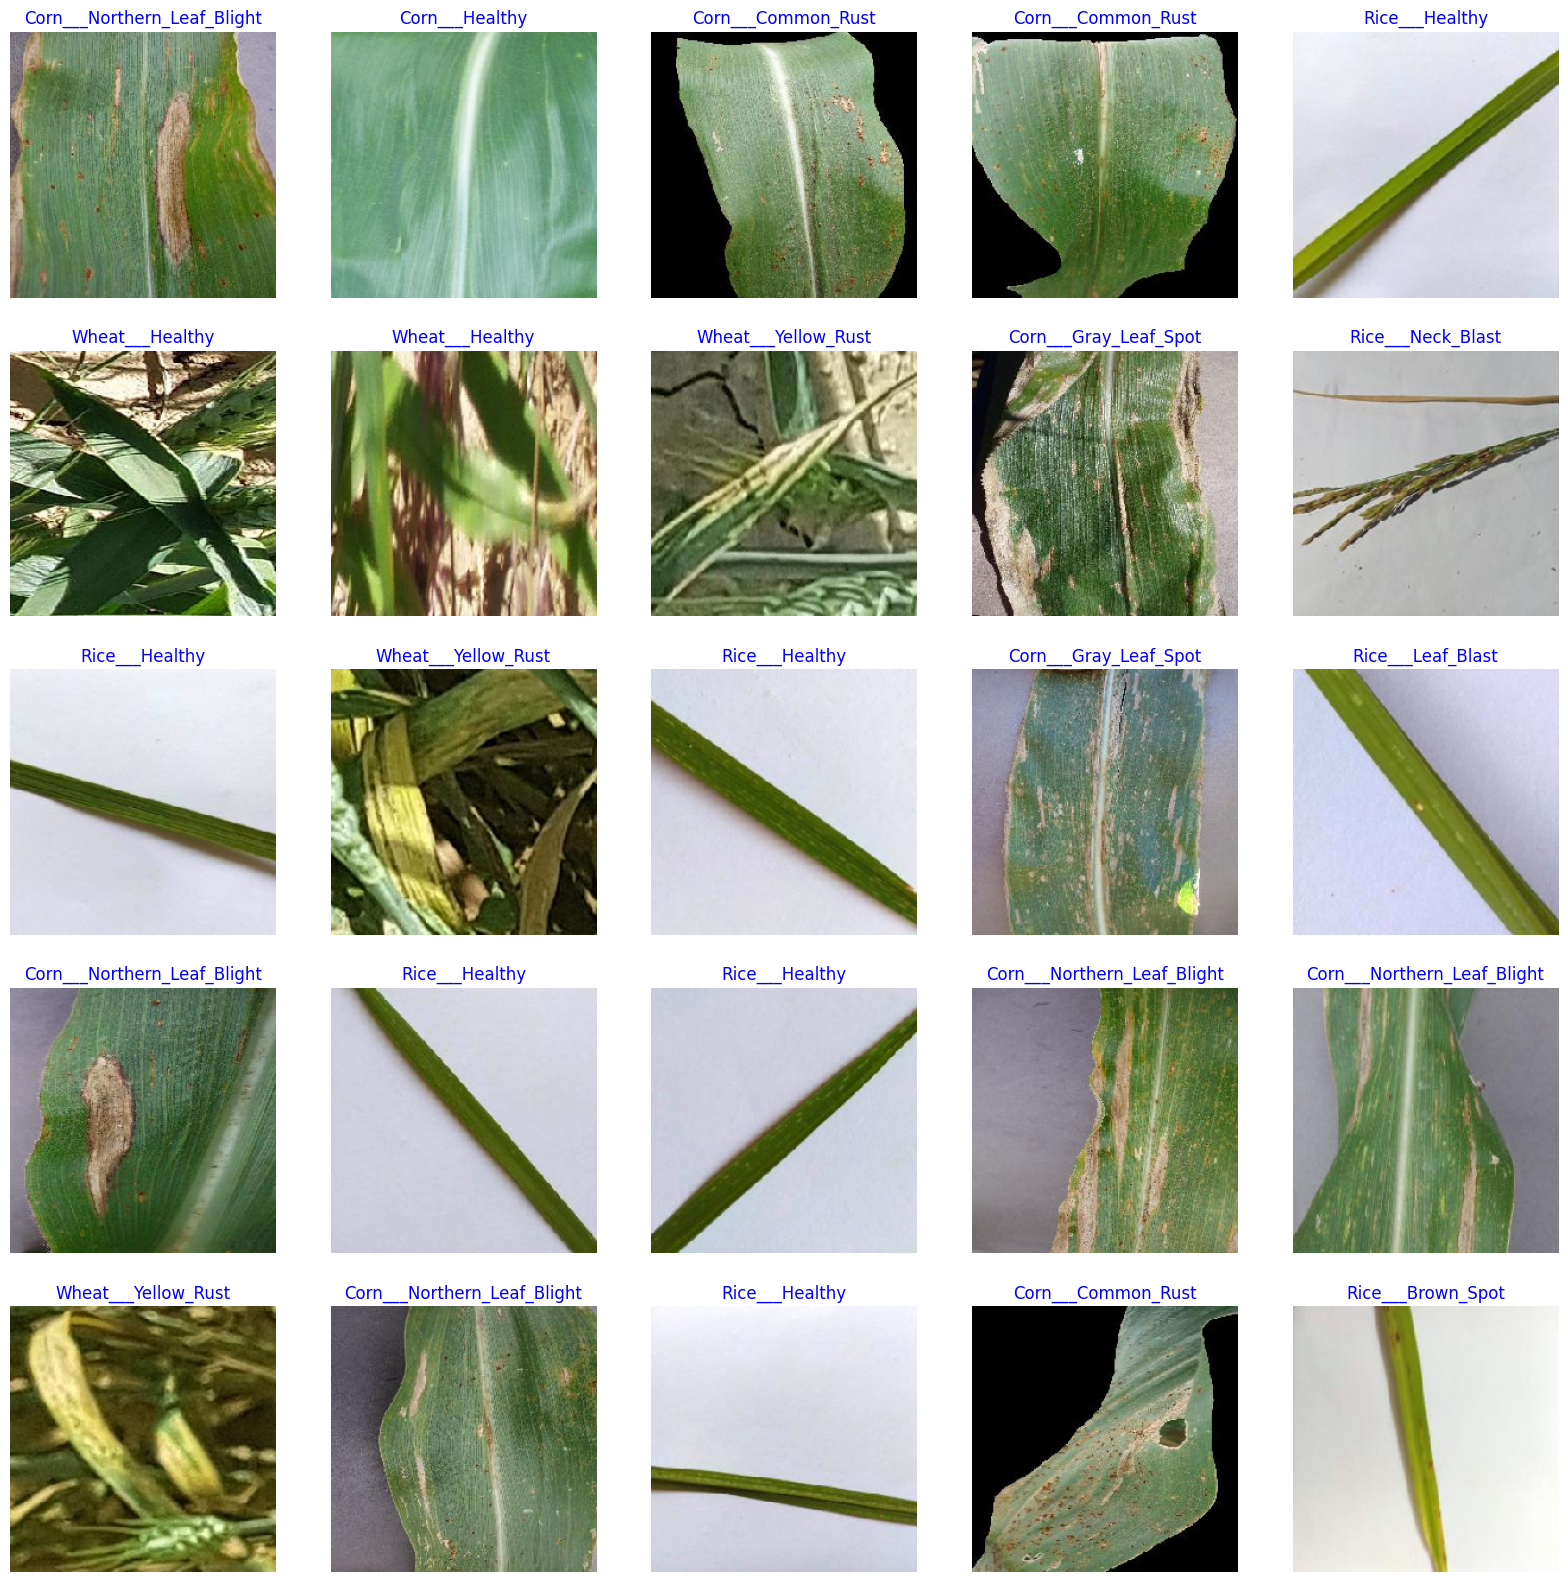

In [4]:
# Display data sample
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()
    
# Display Image Sample
show_images(train_gen)

# Build the model


In [6]:
# Generic Model Creation
hidden_layer = 256
dropout_rate = 0.5
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = EfficientNetB3_model(img_shape, class_count, hidden_layer, dropout_rate)
model.summary()

43941136/43941136 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 sequential (Sequential)     (None, 11)                402443    
                                                                 
Total params: 11185978 (42.67 MB)
Trainable params: 11095603 (42.33 MB)
Non-trainable params: 90375 (353.03 KB)
_________________________________________________________________


Set Callback Parameters

In [7]:
# Set Callback Parameters
batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch)]

Train model

In [8]:
# Train lớp phân loại
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


Display model performance

In [ ]:
plot_training(history)

# Evaluate model

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])